# Agentic RAG with Routing

![agentic-rag](images/agentic-rag.png)

In [40]:
import os
import yaml
from dotenv import load_dotenv
import pprint
##to load credentials
load_dotenv()


True

In [3]:
os.environ["GOOGLE_API_KEY"] = os.getenv("OPENAI_API_KEY") ## Put your OpenAI API key here
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY") ## Put your Tavily Search API key here
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY") ## Put your Langsmith API key here
os.environ["LANGCHAIN_HUB_API_KEY"] = os.getenv("LANGCHAIN_API_KEY") ## Put your Langsmith API key here
os.environ["LANGCHAIN_TRACING_V2"] = 'true' ## Set this as True
os.environ["LANGCHAIN_ENDPOINT"] = 'https://api.smith.langchain.com/' ## Set this as: https://api.smith.langchain.com/
os.environ["LANGCHAIN_HUB_API_URL"] = 'https://api.hub.langchain.com' ## Set this as : https://api.hub.langchain.com
os.environ["LANGCHAIN_PROJECT"] = 'llm-agents'

## Defining Databases for the Query Router

### Web Search Tool

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=3)

In [5]:
web_results = web_search_tool.invoke({"query": "when will interest rates fall?"})
web_results

[{'url': 'https://www.morningstar.com/markets/when-will-fed-start-cutting-interest-rates',
  'content': 'At many points in the past 10 years (when the Fed first started issuing multiyear projections for the fed-funds rate), the Fed has veered from its initial forecasts owing to shifts in the data.\n Then, starting around the beginning of 2024 (we expect in the first meeting in March 2024), we expect the Fed to begin cutting the fed-funds rate.\n U.S. Interest-Rate Forecast: What We See for the Future\nIn the short run, our interest-rate forecast is centered on the Fed and its attempt to smooth out economic cycles. Because the yield curve has inverted so much, the Fed has been forced to hike the federal-funds rate more than it would have otherwise in order to sufficiently cool off the economy.\n When the economy is overheated (the output gap is positive and inflation is high), as today, then the Fed seeks to hike interest rates to slow growth.\n'},
 {'url': 'https://apnews.com/article/f

### Arxiv Search Tool

In [6]:
from langchain_community.utilities.arxiv import ArxivAPIWrapper
arxiv = ArxivAPIWrapper(
    top_k_results = 3,
    ARXIV_MAX_QUERY_LENGTH = 300,
    load_max_docs = 3,
    load_all_available_meta = False,
    doc_content_chars_max = 40000
)
arxiv.run("tree of thought llm")

'Published: 2024-06-09\nTitle: RATT: A Thought Structure for Coherent and Correct LLM Reasoning\nAuthors: Jinghan Zhang, Xiting Wang, Weijieying Ren, Lu Jiang, Dongjie Wang, Kunpeng Liu\nSummary: Large Language Models (LLMs) gain substantial reasoning and decision-making\ncapabilities from thought structures. However, existing methods such as Tree of\nThought and Retrieval Augmented Thoughts often fall short in complex tasks due\nto the limitations of insufficient local retrieval of factual knowledge and\ninadequate global selection of strategies. These limitations make it\nchallenging for these methods to balance factual accuracy and comprehensive\nlogical optimization effectively. To address these limitations, we introduce\nthe Retrieval Augmented Thought Tree (RATT), a novel thought structure that\nconsiders both overall logical soundness and factual correctness at each step\nof the thinking process. Specifically, at every point of a thought branch, RATT\nperforms planning and looka

### Private Database

In [7]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

loader = PyPDFLoader("data/recipes.pdf")
pages = loader.load_and_split()
print(f"We have: {len(pages)} pages")

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(pages)
print(f"We have: {len(doc_splits)} chunks")

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
recipe_retriever = vectorstore.as_retriever()

We have: 64 pages
We have: 126 chunks


In [8]:
docs = recipe_retriever.invoke("How do I make a lentil soup")
print(docs)

[Document(page_content='2. Mix the vegetables with lentils and leave \nto boil for 20 minutes.\n3. Grind lentils, carrots and onion in the \nblender. \n4. Add the remaining ingredients to the soup \nand return to the heat to boil for a while. \n5. Serve the soup and garnish with parsley.\nPreferred for\nRamadan', metadata={'page': 3, 'source': 'data/recipes.pdf'}), Document(page_content='1 teaspoon of ginger \n1 clove garlic \n1 teaspoon of cumin   \n1 tablespoon of tomato paste 4 cups of water \n1 tablespoon soft coriander\na pinch of turmeric\na pinch of salt\nPreparation : \n1.  Wash vegetables and chop finely.2.  Sprinkle the canola oil in the pot then add onions, garlic, ginger and stir until they wilt. \n3.  Add vegetables to pot, starting with potatoes, carrots, celery, pumpkin, zucchini and tomato. \n4.  Mix the vegetables and sprinkle salt, spices, tomato paste and add water then leave on the \nheat for half an hour. \n5.  Sprinkle coriander on hot the soup and serve.Vegetable

## Query Router

### Use semantic routing for fast routing of queries

Learn more here: https://github.com/aurelio-labs/semantic-router

In [9]:
from semantic_router import Route

# we could use this as a guide for our chatbot to avoid political conversations
recipes = Route(
    name="recipes",
    utterances = [
    "How do I make lentil soup?",
    "Share recipe for chicken soup",
    "Do you have any salad recipes?",
    "How do I make falafel?"
    ])

ai = Route(
    name="ai",
    utterances = [
    "What is tree of thought prompting?",
    "Why is dropout using in neural networks?",
    "How was Mistral model trained?",
    "Tell me about RLHF"
    ])

chitchat = Route(
    name="chitchat",
    utterances=[
        "how's the weather today?",
        "how are things going?",
        "plans for the weekend"
    ],
)

# we place both of our decisions together into single list
routes = [recipes, ai, chitchat]


/Users/pdwivedi/miniconda3/envs/llm_agents/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from semantic_router.encoders import OpenAIEncoder
encoder = OpenAIEncoder()

from semantic_router.layer import RouteLayer
rl = RouteLayer(encoder=encoder, routes=routes)

2024-06-15 08:21:41 INFO semantic_router.utils.logger local


In [11]:
print(rl("How do I make onion soup?").name)

recipes


In [12]:
print(rl("What is chain of thought prompting?").name)

ai


In [13]:
print(rl("how do I go from NY to LA?").name)

None


## Retrieval Grader or document grader
<i>This module will grade the quality of retrieved documents </i>

In [14]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from together_llm import TogetherLLM


llm_grader = TogetherLLM(model='meta-llama/Llama-3-8b-chat-hf', temperature=0.2, max_tokens=4)


# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
    Only answer with the binary score as yes or no. I don't need explanation"""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | llm_grader

In [15]:
question = "lentil soup recipe"
docs = recipe_retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content + docs[2].page_content + docs[3].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

/Users/pdwivedi/miniconda3/envs/llm_agents/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


yes


## Generate answer

In [30]:
### Generate

from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Prompt
system_prompt = '''You are an assistant for question-answering tasks. Use the following pieces of retrieved context to 
answer the question. If you don't know the answer, just say that you don't know.
.\nQuestion: {question} \nContext: {context} \nAnswer:
'''

generate_answer_prompt = PromptTemplate(
        input_variables=["context", "question"], template=system_prompt)

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = generate_answer_prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

To make lentil soup, you need to put lentils, carrots, onion, and water in a pot and place it on high heat until boiling, then reduce the heat. Mix the vegetables with lentils and let it boil for 20 minutes. Grind lentils, carrots, and onion in a blender. Add the remaining ingredients to the soup and return it to the heat to boil for a while. Serve the soup and garnish with parsley.


## Define the flow using Langgraph

![Agentic-RAG-block](images/agentic-rag-block.png)

### Graph State

In [31]:
from typing_extensions import TypedDict
from typing import List


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: Question from the user
        route: Route chosen by the Query Router
        documents: list of documents from either RAG, Arxiv or websearch
        score: document relevance score
        answer: final response to user's question
    """

    question: str
    route: str
    documents: str
    score: str
    answer: str

### Define Graph Nodes

In [32]:
def query_router(state):
    """
    Route Queries
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state that contains the route
    """
    print("---ROUTING---")
    question = state["question"]
    chosen_route = ''

    # Retrieval
    if rl(question).name==None:
        chosen_route =  "web_search"
    else:
        chosen_route = rl(question).name
    return {'route': chosen_route}


def retriever(state):
    """
    Retrieving Docs
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state that contains the retrieved documents
    """
    print("---RETRIEVING---")
    chosen_route = state['route']
    question = state['question']
    if chosen_route =='web_search' or chosen_route=='chitchat':
        results = web_search_tool.invoke({"query": question})
        result_content = [result['content'] for result in results]
        docs = '/n'.join(result_content)
    elif chosen_route=='ai':
        docs = arxiv.run(question)
    elif chosen_route=='recipes':
        results = recipe_retriever.invoke(question)
        result_content = [result.page_content for result in results]
        docs = '/n'.join(result_content)
    return {'documents': docs}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Adds a document relevance score to the state
    """

    print("---GRADE DOCUMENT RELEVANCE---")
    question = state["question"]
    documents = state["documents"]

    score = retrieval_grader.invoke({"question": question, "document": documents})
    if score.lower() =="yes":
        print("Documents are relevant")
    else:
        print("Documents are irrelevant")
    return {'score': score.lower()}


def generate_answer(state):
    """
    Determines whether the retrieved documents are relevant to the question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---GENERATE ANSWER---")
    question = state["question"]
    documents = state["documents"]
    score = state['score']
    
    if score == 'no':
        ## Run websearch 
        results = web_search_tool.invoke({"query": question})
        result_content = [result['content'] for result in results]
        documents = '/n'.join(result_content)

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {'answer': generation, 'documents': documents}


### Define Graph Flow

In [33]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)


# Define the nodes
workflow.add_node("query_router", query_router) 
workflow.add_node("retrieve", retriever) 
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate_answer)


## Define Flow
workflow.set_entry_point("query_router")
workflow.add_edge("query_router", "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents", "generate")
workflow.add_edge("generate", END)

graph = workflow.compile()

In [34]:
graph.get_graph().print_ascii()

   +-----------+     
   | __start__ |     
   +-----------+     
          *          
          *          
          *          
  +--------------+   
  | query_router |   
  +--------------+   
          *          
          *          
          *          
    +----------+     
    | retrieve |     
    +----------+     
          *          
          *          
          *          
+-----------------+  
| grade_documents |  
+-----------------+  
          *          
          *          
          *          
    +----------+     
    | generate |     
    +----------+     
          *          
          *          
          *          
    +---------+      
    | __end__ |      
    +---------+      


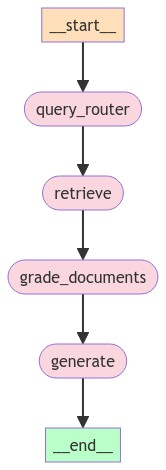

In [35]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

### Run the graph

In [42]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'question': "Share the recipe for cucumber and radish salad",
}, thread):
    print(s)

---ROUTING---
{'query_router': {'route': 'recipes'}}
---RETRIEVING---


Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'retrieve': {'documents': 'decorate with radish.Nutritional value per serving: \n• Calories: 36kcal• Fat: 2g • Saturated fat: 0g • Cholesterol: 0g• Carbohydrates: 4g • Protein: 1g• Sodium: 93mg• Fiber: 1gCucumber and Radish Salad\nPreferred for\nRamadan/nkcal = kilo calories; g = grams; mg = milligrams\nWafaa Helmi Ayesh, Director of Clinical Nutrition Department. Clinical Support Services Sector  - Dubai Health Authority - UAEReference\n© 2013 - LifeScan Middle East & Africa a division of Johnson & Johnson (Middle East) Inc - AW MEA 0313CG-MEANAR-ED1.Ingredients:\n10 radishes \n2 pieces seedless cucumber \n1 fresh hot pepper cut into rings without seeds  \n2 tablespoons chopped fresh basil\n½ teaspoon sugar\n1/4 teaspoon salt \n1 tablespoon olive oil \n1 tablespoon vinegar\nPreparation:\n1. Take one piece of radish aside for decoration. \n2. Then cut 5 radishes into slices, and cut the rest of the radishes into halves or four. \n3. Cut the cucumber into strips.\n4. Take a pot and mix

Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


Documents are relevant
{'grade_documents': {'score': 'yes'}}
---GENERATE ANSWER---


Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'generate': {'documents': 'decorate with radish.Nutritional value per serving: \n• Calories: 36kcal• Fat: 2g • Saturated fat: 0g • Cholesterol: 0g• Carbohydrates: 4g • Protein: 1g• Sodium: 93mg• Fiber: 1gCucumber and Radish Salad\nPreferred for\nRamadan/nkcal = kilo calories; g = grams; mg = milligrams\nWafaa Helmi Ayesh, Director of Clinical Nutrition Department. Clinical Support Services Sector  - Dubai Health Authority - UAEReference\n© 2013 - LifeScan Middle East & Africa a division of Johnson & Johnson (Middle East) Inc - AW MEA 0313CG-MEANAR-ED1.Ingredients:\n10 radishes \n2 pieces seedless cucumber \n1 fresh hot pepper cut into rings without seeds  \n2 tablespoons chopped fresh basil\n½ teaspoon sugar\n1/4 teaspoon salt \n1 tablespoon olive oil \n1 tablespoon vinegar\nPreparation:\n1. Take one piece of radish aside for decoration. \n2. Then cut 5 radishes into slices, and cut the rest of the radishes into halves or four. \n3. Cut the cucumber into strips.\n4. Take a pot and mix

In [43]:
pprint.pprint(s['generate']['answer'])

('Cucumber and Radish Salad Recipe:\n'
 '\n'
 'Ingredients:\n'
 '- 10 radishes\n'
 '- 2 seedless cucumbers\n'
 '- 1 fresh hot pepper (without seeds), cut into rings\n'
 '- 2 tablespoons chopped fresh basil\n'
 '- 1/2 teaspoon sugar\n'
 '- 1/4 teaspoon salt\n'
 '- 1 tablespoon olive oil\n'
 '- 1 tablespoon vinegar\n'
 '\n'
 'Preparation:\n'
 '1. Set aside one radish for decoration.\n'
 '2. Slice 5 radishes and cut the rest into halves or quarters.\n'
 '3. Cut the cucumbers into strips.\n'
 '4. In a bowl, mix the sliced radishes, cucumber strips, hot pepper, basil, '
 'sugar, and salt.\n'
 '5. Add olive oil and vinegar, then lightly mix to blend with the '
 'vegetables.\n'
 '6. Decorate with the remaining radish.\n'
 '\n'
 'Enjoy your Cucumber and Radish Salad!')


In [44]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'question': "What is Chain of Thought prompting?",
}, thread):
    print(s)

---ROUTING---
{'query_router': {'route': 'ai'}}
---RETRIEVING---
{'retrieve': {'documents': 'Published: 2024-05-09\nTitle: Hypothesis Testing Prompting Improves Deductive Reasoning in Large Language Models\nAuthors: Yitian Li, Jidong Tian, Hao He, Yaohui Jin\nSummary: Combining different forms of prompts with pre-trained large language models\nhas yielded remarkable results on reasoning tasks (e.g. Chain-of-Thought\nprompting). However, along with testing on more complex reasoning, these\nmethods also expose problems such as invalid reasoning and fictional reasoning\npaths. In this paper, we develop \\textit{Hypothesis Testing Prompting}, which\nadds conclusion assumptions, backward reasoning, and fact verification during\nintermediate reasoning steps. \\textit{Hypothesis Testing prompting} involves\nmultiple assumptions and reverses validation of conclusions leading to its\nunique correct answer. Experiments on two challenging deductive reasoning\ndatasets ProofWriter and RuleTaker sh

Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


Documents are relevant
{'grade_documents': {'score': 'yes'}}
---GENERATE ANSWER---


Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'generate': {'documents': 'Published: 2024-05-09\nTitle: Hypothesis Testing Prompting Improves Deductive Reasoning in Large Language Models\nAuthors: Yitian Li, Jidong Tian, Hao He, Yaohui Jin\nSummary: Combining different forms of prompts with pre-trained large language models\nhas yielded remarkable results on reasoning tasks (e.g. Chain-of-Thought\nprompting). However, along with testing on more complex reasoning, these\nmethods also expose problems such as invalid reasoning and fictional reasoning\npaths. In this paper, we develop \\textit{Hypothesis Testing Prompting}, which\nadds conclusion assumptions, backward reasoning, and fact verification during\nintermediate reasoning steps. \\textit{Hypothesis Testing prompting} involves\nmultiple assumptions and reverses validation of conclusions leading to its\nunique correct answer. Experiments on two challenging deductive reasoning\ndatasets ProofWriter and RuleTaker show that hypothesis testing prompting not\nonly significantly impr

In [45]:
pprint.pprint(s['generate']['answer'])

('Chain of Thought prompting is a method that primes large language models to '
 'verbalize rationalization for their predictions. It involves guiding the '
 'model through a series of reasoning steps to improve reasoning accuracy and '
 'generate a more reasonable and standardized reasoning process.')


In [46]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'question': "What are the different ways to go from NY to LA and which is the cheapest?",
}, thread):
    print(s)

---ROUTING---
{'query_router': {'route': 'web_search'}}
---RETRIEVING---


Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'retrieve': {'documents': 'Change currency. Feedback. Help. Flights from New York to Los Angeles. Use Google Flights to plan your next trip and find cheap one way or round trip flights from New York to Los Angeles./nNonstop departures\nMonday\nAeromexico, Air China, Air Europa, +27 more\nAeromexico, Air China, +28 more\n26\n27\nTuesday\nAeromexico, Air Europa, Air France, +28 more\nAeromexico, Air Europa, +29 more\n27\n28\nWednesday\nAeromexico, Air China, Air Europa, +27 more\nAeromexico, Air China, +28 more\n26\n27\nThursday\nAeromexico, Air Europa, Air France, +26 more\nAeromexico, Air Europa, +27 more\n25\n26\nFriday\nAeromexico, Air Europa, Air France, +27 more\nAeromexico, Air Europa, +28 more\n26\n27\nSaturday\nAeromexico, Air China, Air Europa, +27 more\nAeromexico, Air China, +28 more\n26\n27\nSunday\nAeromexico, Air Europa, Air France, +26 more\nAeromexico, Air Europa, +27 more\n25\n26\nNonstop returns\nMonday\nAeromexico, Air Europa, Air France, +26 more\nAeromexico, Air Eu

Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


Documents are relevant
{'grade_documents': {'score': 'yes'}}
---GENERATE ANSWER---


Error in LangChainTracer.on_chain_end callback: AttributeError("'NoneType' object has no attribute 'append'")


{'generate': {'documents': 'Change currency. Feedback. Help. Flights from New York to Los Angeles. Use Google Flights to plan your next trip and find cheap one way or round trip flights from New York to Los Angeles./nNonstop departures\nMonday\nAeromexico, Air China, Air Europa, +27 more\nAeromexico, Air China, +28 more\n26\n27\nTuesday\nAeromexico, Air Europa, Air France, +28 more\nAeromexico, Air Europa, +29 more\n27\n28\nWednesday\nAeromexico, Air China, Air Europa, +27 more\nAeromexico, Air China, +28 more\n26\n27\nThursday\nAeromexico, Air Europa, Air France, +26 more\nAeromexico, Air Europa, +27 more\n25\n26\nFriday\nAeromexico, Air Europa, Air France, +27 more\nAeromexico, Air Europa, +28 more\n26\n27\nSaturday\nAeromexico, Air China, Air Europa, +27 more\nAeromexico, Air China, +28 more\n26\n27\nSunday\nAeromexico, Air Europa, Air France, +26 more\nAeromexico, Air Europa, +27 more\n25\n26\nNonstop returns\nMonday\nAeromexico, Air Europa, Air France, +26 more\nAeromexico, Air Eu

In [47]:
pprint.pprint(s['generate']['answer'])

('The most efficient and cheapest way to travel from New York to Los Angeles '
 'is by flying, with prices ranging from $100 to $430.')
